<a href="https://colab.research.google.com/github/DiegoMBrito/MVP_Sprint1/blob/main/MVP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo da ocorrência de terremotos entre os anos de 2003 - 2023

Os terremotos são um dos desastres naturais mais destrutivos e imprevisíveis do mundo, causando danos significativos de várias formas à vida humana. Embora os cientistas tenham feito progressos significativos na previsão de terremotos, ainda não é possível saber com antecedência onde ocorrerá um terromoto. 

As ondas sísmicas emitidas pelos terremotos podem ser detectadas, registradas e analisadas através de aparelhos chamados sismógrafos. Desta análise pode-se obter informações sobre a localização precisa do terremoto (epicentro), sua profundidade, energia liberada, o mecanismo gerador do abalo, e o meio que as ondas percorreram para chegar ao local onde foram geradas até o sensor que as detectou.

O dataset em estudo foi criado através de registros dos últimos 20 anos, com várias informações sobre tremores com magnitude entre 6,5 e 9,1 na escala Richter.

ESCREVER UM PARÁGRAFO SOBRE METODOLIA QUE SERÁ USADA. (Nesse estudo usaremos o Aprendizado Não Supervisonado, pois não temos o dado de saída. A ideia é usar a Clusterização (agrupamento) para indicar as localidades com maior número de ocorrências recentes (2000 - 2023) de terremotos.)

Este projeto visa usar técnicas avançadas de aprendizado de máquina para desenvolver um modelo confiável para previsão de terremotos. Desta forma, será possível contribuir para melhor compreensão desses eventos naturais e minimizar danos, principalmente perda de vidas.



# Carga do Dataset Earthquake

In [1]:
# Importações de libs necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from pandas.core.frame import Axis
import missingno as ms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import requests


In [2]:
# Como vou trabalhar com mapas, irei instalar o basemap e o cartopy
# Instala o basemap e cartopy
! pip install basemap
! pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.2/859.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 63.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102753 sha256=ef294d229ac98c378af2600add546f3ae115353c16480f742cf50b0169e1fc88
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy


In [3]:
# Importa libs necessárias para uso de mapas
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes as geoaxes

In [4]:
# Importa dados de um arquivo .csv do repositório github
# Dataset de registros de ocorrência de terremotos entre 1/1/2003 e 1/1/2023, fonte: https://www.kaggle.com/datasets/warcoder/earthquake-dataset

# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/DiegoMBrito/MVP_Sprint1/main/data/earthq2_MVP.csv"

# Lê o arquivo .csv
earthquake = pd.read_csv(url, sep=',')

# Verifica o tipo de earthquake
print(type(earthquake))

<class 'pandas.core.frame.DataFrame'>


# Análise Exploratória de Dados do dataset earthquake

In [5]:
# Mostra as dimensões do dataset earthquake (instâncias e atributos)
earthquake.shape

(774, 17)

In [6]:
# Exibe os nomes das colunas
earthquake.columns

Index(['title', 'magnitude', 'date', 'time', 'cdi', 'mmi', 'alert', 'tsunami',
       'sig', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'location',
       'continent', 'country'],
      dtype='object')

### Descrição dos atributos do dataset:

- Title - Nome dado ao evento;
- Magnitude - Magnitude (medido na escala Richter) do terremoto;
- Date - Dia do evento;
- Time - Hora do evento;
- CDI - Mostra a intensidade máxima relatada para o intervalo do evento;
- MMI - Mostra a intensidade instrumental máxima estimada para o evento;
- Alert - Nível do alerta, verde, amarelo, laranja e vermelho;
- Tsumani - '1' para ocorrências na crosta marinha e '0' para ocorrências na crosta - continental;
- SIG - Número que descreve a importância do evento. Números maiores indicam um evento mais significativo. Esse valor é determinado por vários fatores, incluindo: magnitude, MMI máximo, relatórios de feltro e impacto estimado;
- DMIN - Distância horizontal do epicentro até a estação de medição mais próxima;
- GAP - O maior intervalo azimutal entre estações adjacentes azimutalmente (em graus). Em geral, quanto menor esse número, mais confiável é a posição horizontal calculada do terremoto (locais de terremotos nos quais a lacuna azimutal excede 180 graus geralmente apresentam grandes incertezas de localização e profundidade);
- DEPTH - A profundidade onde o terremoto começa a se formar (Epicentro);
- Latitude/Longitude - Coordedanadas geográficas do local do terremoto;
- Continent - Continente de ocorrência do evento;
- Country - Cidade de ocorrência (proximidade) do evento.

In [7]:
# Mostra as informações do dataset earthquake (informações sobre o tipo de dados dos atributos)
earthquake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      774 non-null    object 
 1   magnitude  774 non-null    float64
 2   date       774 non-null    object 
 3   time       774 non-null    object 
 4   cdi        774 non-null    int64  
 5   mmi        774 non-null    int64  
 6   alert      774 non-null    object 
 7   tsunami    774 non-null    int64  
 8   sig        774 non-null    int64  
 9   dmin       774 non-null    float64
 10  gap        774 non-null    float64
 11  depth      774 non-null    float64
 12  latitude   774 non-null    float64
 13  longitude  774 non-null    float64
 14  location   774 non-null    object 
 15  continent  774 non-null    object 
 16  country    774 non-null    object 
dtypes: float64(6), int64(4), object(7)
memory usage: 102.9+ KB


In [8]:
# Exibe as 5 primiras linhas do dataset
earthquake.head()

,title,magnitude,date,time,cdi,mmi,alert,tsunami,sig,dmin,gap,depth,latitude,longitude,location,continent,country
0,M 7.0,7.0,22/11/2022,2:03:00 AM,8,7,green,1,768,0.509,17.0,14.000,-9.7963,159.596,Malango- Solomon Islands,Oceania,Solomon Islands
1,M 6.9,6.9,18/11/2022,1:37:00 PM,4,4,green,0,735,2.229,34.0,25.000,-4.9559,100.738,Bengkulu- Indonesia,Asia,Indonesia
2,M 7.3,7.3,11/11/2022,10:48:00 AM,5,5,green,1,833,1.865,21.0,37.000,-19.2918,-172.129,Neiafu- Tonga,Oceania,Tonga
3,M 7.0,7.0,9/11/2022,9:51:00 AM,4,3,green,1,755,4.578,26.0,660.000,-26.0442,178.381,the Fiji Islands,Oceania,Fiji
4,M 6.8,6.8,9/11/2022,9:38:00 AM,1,3,green,1,711,4.678,22.0,630.379,-25.9678,178.363,the Fiji Islands,Oceania,Fiji


In [9]:
# Exibe as 5 últimas linhas do dataset
earthquake.tail()

,title,magnitude,date,time,cdi,mmi,alert,tsunami,sig,dmin,gap,depth,latitude,longitude,location,continent,country
769,M 7.7,7.7,31/03/2020,11:53:00 PM,0,8,green,0,912,0.0,0.0,60.0,13.0490,-88.660,Puerto El Triunfo- El Salvador,Central America,El Salvador
770,M 6.9,6.9,25/03/2020,2:50:00 AM,5,7,green,0,745,0.0,0.0,36.4,56.7744,-153.281,Old Harbor- Alaska,North America,USA
771,M 7.1,7.1,13/02/2020,10:34:00 AM,0,7,green,0,776,0.0,0.0,103.0,-14.9280,167.170,Port-Olry- Vanuatu,Oceania,Vanuatu
772,M 6.8,6.8,28/01/2020,7:11:00 PM,0,5,green,0,711,0.0,0.0,33.0,6.6310,126.899,Mindanao- Philippines,Asia,Philippines
773,M 7.5,7.5,24/01/2020,5:56:00 PM,0,7,green,0,865,0.0,0.0,33.0,6.8980,126.579,Lukatan- Philippines,Asia,Philippines


In [10]:
# Verifica se há valores nulls no dataset (indica quantidade de valores ausentes em cada atributo do dataset)
earthquake.isnull().sum()

title        0
magnitude    0
date         0
time         0
cdi          0
mmi          0
alert        0
tsunami      0
sig          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
location     0
continent    0
country      0
dtype: int64

# Pré-Pocessamento dos dados

In [11]:
# Criação de um novo dataframe para não alterar o original.
df_earth = pd.DataFrame(earthquake)

Remoção de algumas colunas que não irei usar do dataset.

In [12]:
del df_earth["title"]

In [13]:
del df_earth["time"]

Os valores de GAP maiores que 180 graus apresentam alta incertezas quanto a acuracia dos dados, por isso serão exluídos.

In [14]:
# Seleciona os valores de GAP maiores que 180 graus
df_earth[df_earth['gap'] > 180]

,magnitude,date,cdi,mmi,alert,tsunami,sig,dmin,gap,depth,latitude,longitude,location,continent,country
30,6.5,11/1/2022,0,3,green,1,650,0.0000,208.8,37.000,52.5020,-168.080,Nikolski- Alaska,North America,USA
33,6.7,11/1/2022,0,4,green,1,691,0.0000,205.2,33.000,52.4800,-167.736,Nikolski- Alaska,North America,USA
168,6.9,4/5/2018,7,8,yellow,1,1392,0.1100,210.0,5.810,19.3182,-155.000,Leilani Estates- Hawaii,Oceania,USA
351,6.8,10/3/2014,5,5,green,1,1211,0.6568,229.0,16.441,40.8287,-125.134,Indianola- California,North America,USA
499,7.2,4/4/2010,9,9,red,0,2910,0.5137,239.0,9.987,32.2862,-115.295,Delta- B.C.- MX,North America,Mexico
512,6.5,10/1/2010,7,7,yellow,0,1360,0.3225,220.0,28.737,40.6520,-124.692,Ferndale- California,North America,USA


In [15]:
# Remove os valores de GAP maiores que 180 graus
df_earth = df_earth.drop(index=df_earth[df_earth['gap'] > 180].index)

In [16]:
# Verifica se os valores foram removidos
df_earth[df_earth['gap'] > 180]

,magnitude,date,cdi,mmi,alert,tsunami,sig,dmin,gap,depth,latitude,longitude,location,continent,country


#### Tratamento de valores missings

Mesmo não havendo valores missings no dataset, há resultados em algumas colunas que não fazem sentido ter o valor "0". Por isso irei tratar esses resultados substituindo os mesmo pela mediana.

<Axes: >

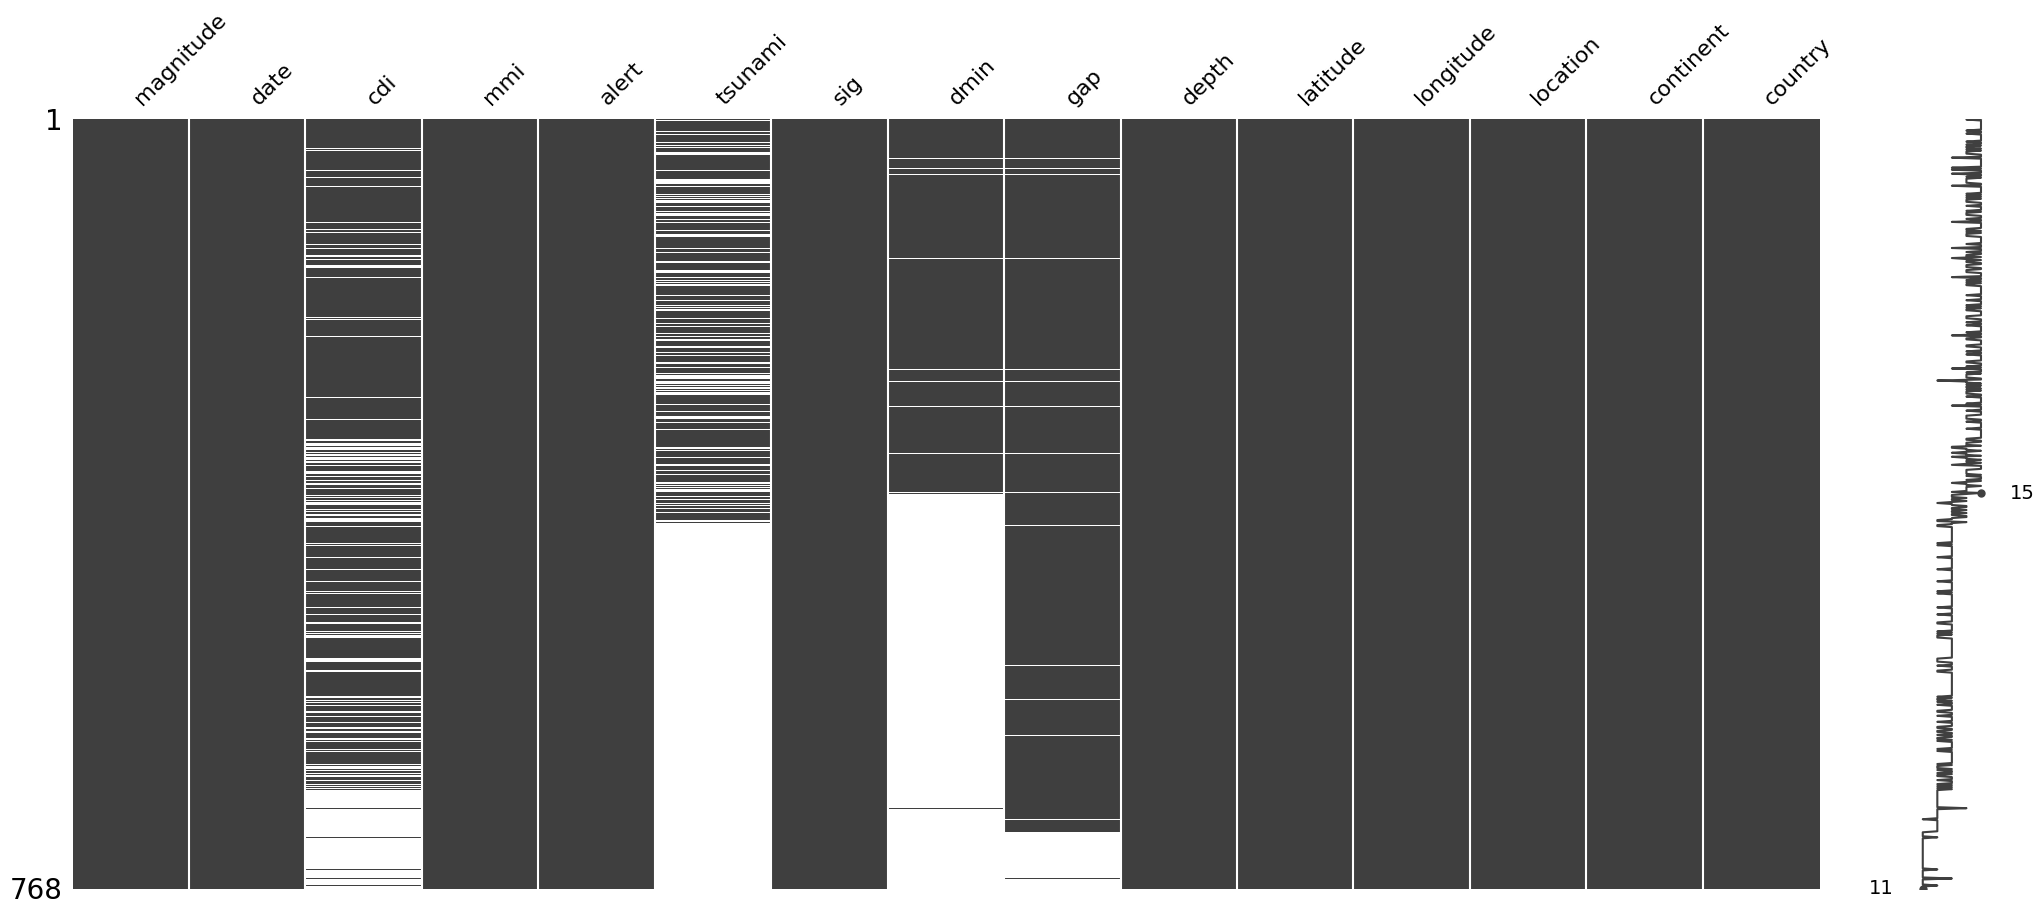

In [17]:
# Substitui os zeros por NaN em todo o dataframe
df_earth.replace(0, np.nan, inplace=True)

# Exibi a visualização matricial da nulidade do dataframe
ms.matrix(df_earth)

In [18]:
# Verificando novamente os valores nulls no dataframe
df_earth.isnull().sum()

magnitude      0
date           0
cdi          207
mmi            0
alert          0
tsunami      475
sig            0
dmin         402
gap           70
depth          0
latitude       0
longitude      0
location       0
continent      0
country        0
dtype: int64

<Axes: >

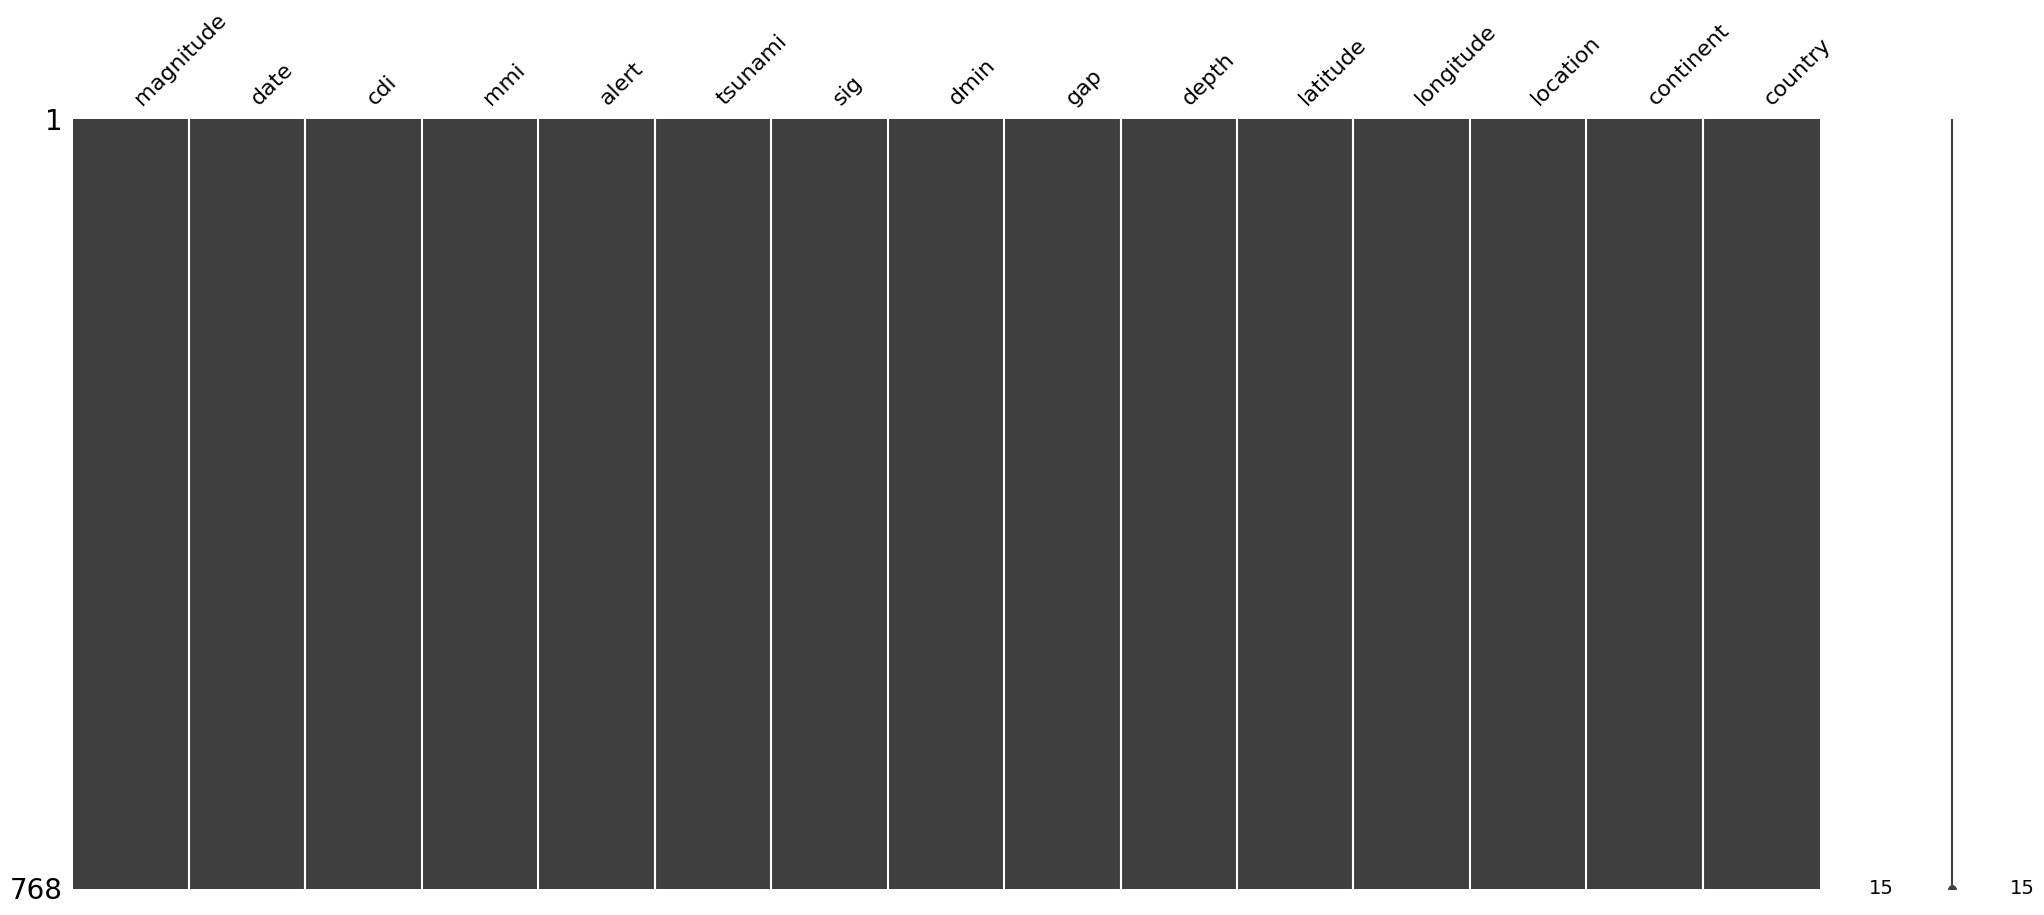

In [19]:
# Substituindo os NaN de 'gap' e 'tsunami' por 0 - voltando aos valores originais destas colunas
df_earth['gap'].fillna(0, inplace=True)
df_earth['tsunami'].fillna(0, inplace=True)

# Substituindo os NaN de 'cdi'e 'dmin' pela mediana da coluna, pois valores '0' para esses atríbutos não fazem sentido no estudo
df_earth['cdi'].fillna(df_earth['cdi'].median(), inplace=True)
df_earth['dmin'].fillna(df_earth['dmin'].median(), inplace=True)

# Exibi a visualização matricial da nulidade do dataframe
ms.matrix(df_earth)

In [20]:
# Exibi as 10 últimas linhas para ver os valores atualizados
df_earth.tail(10)

,magnitude,date,cdi,mmi,alert,tsunami,sig,dmin,gap,depth,latitude,longitude,location,continent,country
764,7.1,3/7/2020,6.0,7,green,0.0,776,1.9915,0.0,35.0,1.2710,126.249,Ternate- Indonesia,Asia,Indonesia
765,7.4,15/05/2020,6.0,6,green,0.0,842,1.9915,0.0,36.0,-4.6800,102.562,Bengkulu- Indonesia,Asia,Indonesia
766,6.6,12/5/2020,6.0,8,green,0.0,670,1.9915,0.0,10.0,13.6710,-88.938,Cojutepeque- El Salvador,Central America,El Salvador
767,7.7,6/5/2020,6.0,9,green,0.0,912,1.9915,0.0,16.0,23.4190,70.232,Bhach?u- India,Asia,India
768,6.9,2/5/2020,6.0,6,green,0.0,732,1.9915,0.0,28.0,-4.0220,101.776,Bengkulu- Indonesia,Asia,Indonesia
769,7.7,31/03/2020,6.0,8,green,0.0,912,1.9915,0.0,60.0,13.0490,-88.660,Puerto El Triunfo- El Salvador,Central America,El Salvador
770,6.9,25/03/2020,5.0,7,green,0.0,745,1.9915,0.0,36.4,56.7744,-153.281,Old Harbor- Alaska,North America,USA
771,7.1,13/02/2020,6.0,7,green,0.0,776,1.9915,0.0,103.0,-14.9280,167.170,Port-Olry- Vanuatu,Oceania,Vanuatu
772,6.8,28/01/2020,6.0,5,green,0.0,711,1.9915,0.0,33.0,6.6310,126.899,Mindanao- Philippines,Asia,Philippines
773,7.5,24/01/2020,6.0,7,green,0.0,865,1.9915,0.0,33.0,6.8980,126.579,Lukatan- Philippines,Asia,Philippines


#### Ajuste no formato do atributo date para poder trabalhar somente com o ano

In [21]:
# Criação de um novo dataframe para fazer o tratamento da data
df_ano = pd.DataFrame(df_earth)

In [22]:
# Converte a coluna date para o formato datetime
df_ano['date'] = pd.to_datetime(df_ano['date'], format='%d/%m/%Y')

# Cria uma nova coluna no DataFrame separando o ano do dia/mês.
df_ano['year'] = df_ano['date'].dt.year

In [23]:
# Exibi as últimas linhas para ver os valores atualizados
df_ano.tail()

,magnitude,date,cdi,mmi,alert,tsunami,sig,dmin,gap,depth,latitude,longitude,location,continent,country,year
769,7.7,2020-03-31,6.0,8,green,0.0,912,1.9915,0.0,60.0,13.0490,-88.660,Puerto El Triunfo- El Salvador,Central America,El Salvador,2020
770,6.9,2020-03-25,5.0,7,green,0.0,745,1.9915,0.0,36.4,56.7744,-153.281,Old Harbor- Alaska,North America,USA,2020
771,7.1,2020-02-13,6.0,7,green,0.0,776,1.9915,0.0,103.0,-14.9280,167.170,Port-Olry- Vanuatu,Oceania,Vanuatu,2020
772,6.8,2020-01-28,6.0,5,green,0.0,711,1.9915,0.0,33.0,6.6310,126.899,Mindanao- Philippines,Asia,Philippines,2020
773,7.5,2020-01-24,6.0,7,green,0.0,865,1.9915,0.0,33.0,6.8980,126.579,Lukatan- Philippines,Asia,Philippines,2020


# Análise Exploratória de Dados do dataframe após o pré-processamento

In [24]:
# Mostra as informações do dataframe (informações sobre o tipo de dados dos atributos)
df_earth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 773
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   magnitude  768 non-null    float64       
 1   date       768 non-null    datetime64[ns]
 2   cdi        768 non-null    float64       
 3   mmi        768 non-null    int64         
 4   alert      768 non-null    object        
 5   tsunami    768 non-null    float64       
 6   sig        768 non-null    int64         
 7   dmin       768 non-null    float64       
 8   gap        768 non-null    float64       
 9   depth      768 non-null    float64       
 10  latitude   768 non-null    float64       
 11  longitude  768 non-null    float64       
 12  location   768 non-null    object        
 13  continent  768 non-null    object        
 14  country    768 non-null    object        
 15  year       768 non-null    int64         
dtypes: datetime64[ns](1), float64(8), int64(3), 

In [68]:
# Mostra um resumo estatístico do dataframe (média, desvio padrão, mínimo, máximo e os quartis)
df_earth.drop(['latitude', 'longitude'], axis=1).describe()

,magnitude,cdi,mmi,tsunami,sig,dmin,gap,depth,year
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,6.944089,5.968750,5.981771,0.381510,867.640625,2.333952,23.517565,74.892621,2014.683594
std,0.448138,1.744894,1.443298,0.486074,315.063154,1.691272,17.314591,135.188049,5.328836
min,6.500000,1.000000,1.000000,0.000000,650.000000,0.046160,0.000000,2.700000,2004.000000
25%,6.600000,5.000000,5.000000,0.000000,691.000000,1.991500,14.100000,14.217500,2010.000000
50%,6.800000,6.000000,6.000000,0.000000,754.000000,1.991500,20.000000,26.295000,2015.000000
75%,7.100000,7.000000,7.000000,1.000000,905.250000,1.991500,29.100000,50.000000,2020.000000
max,9.100000,9.000000,9.000000,1.000000,2910.000000,17.654000,126.000000,670.810000,2022.000000


In [69]:
# Mostra a correlação de Pearson
df_earth.drop(['latitude', 'longitude'], axis=1).corr(method='pearson')

<ipython-input-69-5e925fc1a3e3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_earth.drop(['latitude', 'longitude'], axis=1).corr(method='pearson')


,magnitude,cdi,mmi,tsunami,sig,dmin,gap,depth,year
magnitude,1.000000,0.266538,0.285425,-0.000107,0.528770,-0.051860,-0.123712,0.033061,-0.093013
cdi,0.266538,1.000000,0.470364,0.026373,0.473077,-0.176557,0.061198,-0.227009,0.108445
mmi,0.285425,0.470364,1.000000,-0.131315,0.437204,-0.253928,-0.029799,-0.498275,-0.066693
tsunami,-0.000107,0.026373,-0.131315,1.000000,-0.006519,0.138067,0.118672,0.046065,0.363774
sig,0.528770,0.473077,0.437204,-0.006519,1.000000,-0.142881,0.016327,-0.082662,-0.000654
dmin,-0.051860,-0.176557,-0.253928,0.138067,-0.142881,1.000000,-0.102252,0.112334,0.127371
gap,-0.123712,0.061198,-0.029799,0.118672,0.016327,-0.102252,1.000000,-0.124363,0.026533
depth,0.033061,-0.227009,-0.498275,0.046065,-0.082662,0.112334,-0.124363,1.000000,0.077261
year,-0.093013,0.108445,-0.066693,0.363774,-0.000654,0.127371,0.026533,0.077261,1.000000


Verificação da distribuição das classes nos atributos do dataframe

In [27]:
df_earth.groupby('magnitude').size()

magnitude
6.50    128
6.60    113
6.70     97
6.80     77
6.90     72
7.00     48
7.10     43
7.20     29
7.30     31
7.40     18
7.50     22
7.60     22
7.70     16
7.80     15
7.90      9
8.00      5
8.10      6
8.16      1
8.20      6
8.30      3
8.40      2
8.60      2
8.80      1
9.10      2
dtype: int64

In [28]:
df_earth.groupby('cdi').size()

cdi
1.0     14
2.0     13
3.0     45
4.0     61
5.0    106
6.0    284
7.0     94
8.0     86
9.0     65
dtype: int64

In [29]:
df_earth.groupby('mmi').size()

mmi
1      1
2      3
3     36
4     86
5    139
6    202
7    207
8     67
9     27
dtype: int64

In [70]:
df_earth.groupby('alert').size()

alert
green     613
orange     28
red        12
yellow    115
dtype: int64

In [30]:
df_earth.groupby('tsunami').size()

tsunami
0.0    475
1.0    293
dtype: int64

In [31]:
df_earth.groupby('sig').size()

sig
650     49
651     10
652      6
653      5
654      3
        ..
2504     1
2790     1
2820     1
2840     1
2910     1
Length: 335, dtype: int64

In [32]:
df_earth.groupby('dmin').size()

dmin
0.04616     1
0.04685     1
0.07000     1
0.13300     1
0.13500     1
           ..
10.66900    1
11.41100    1
11.76400    1
12.89600    1
17.65400    1
Length: 358, dtype: int64

In [33]:
df_earth.groupby('gap').size()

gap
0.0      70
8.0       1
8.7       1
9.0       7
9.5       2
         ..
114.0     1
119.0     1
123.0     1
124.0     1
126.0     1
Length: 250, dtype: int64

In [34]:
df_earth.groupby('depth').size()

depth
2.700      1
4.200      2
5.000      3
6.000      1
6.430      2
          ..
630.000    1
630.379    1
660.000    1
664.000    1
670.810    1
Length: 296, dtype: int64

In [35]:
df_earth.groupby('country').size()

country
Afghanistan           6
Algeria               1
Antarctica            6
Argentina             2
Australia             1
                     ..
USA                  39
United Kingdom        6
Vanuatu              43
Venezuela             1
Wallis and Futuna     3
Length: 63, dtype: int64

In [36]:
df_earth.groupby('continent').size()

continent
Africa               5
Asia               296
Central America     35
Europe              19
North America       75
Oceania            245
South America       93
dtype: int64

#### Visualizações Unimodais

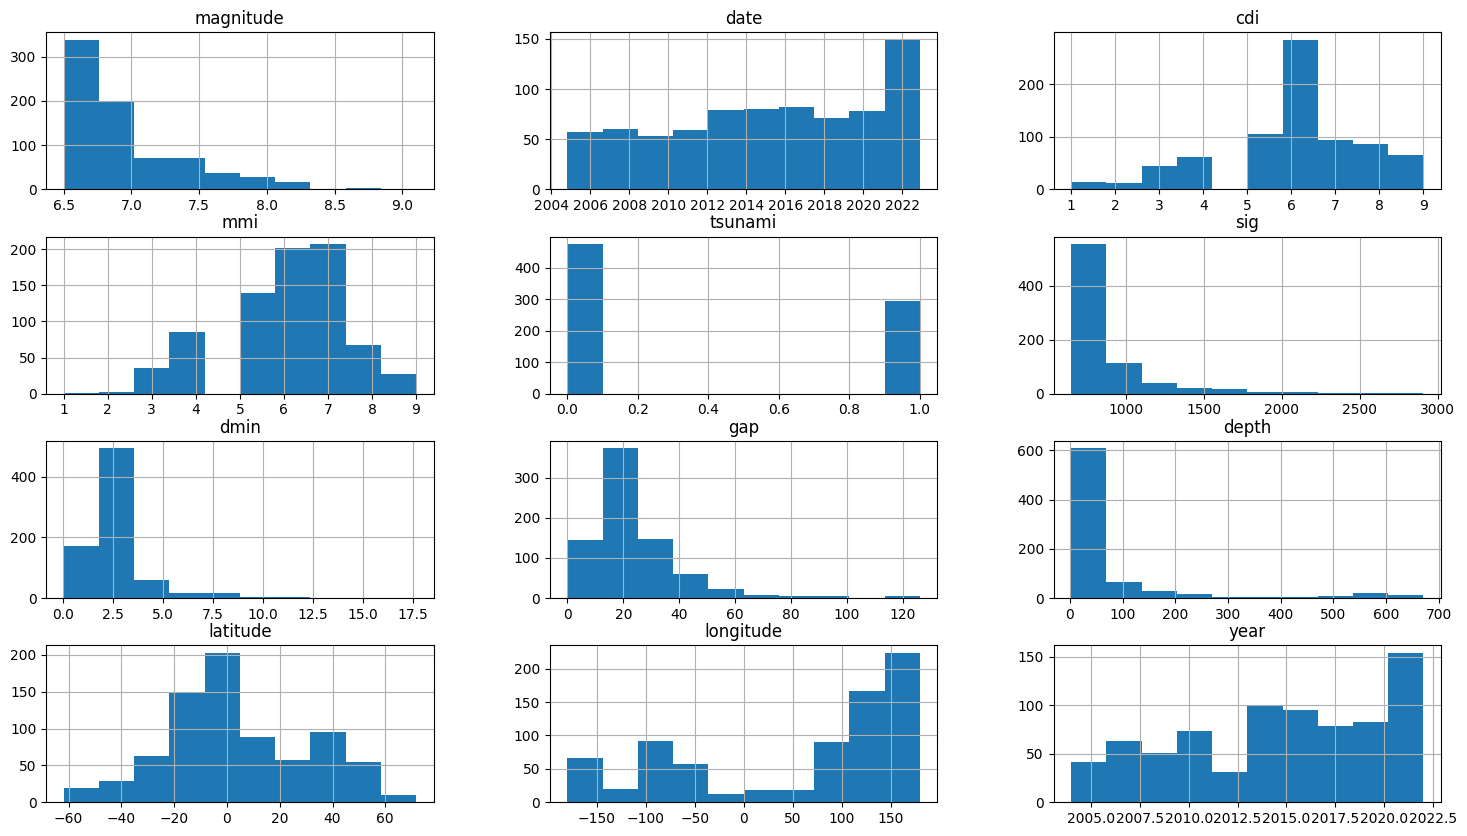

In [37]:
# Histograma
df_earth.hist(figsize = (18,10))
plt.show()

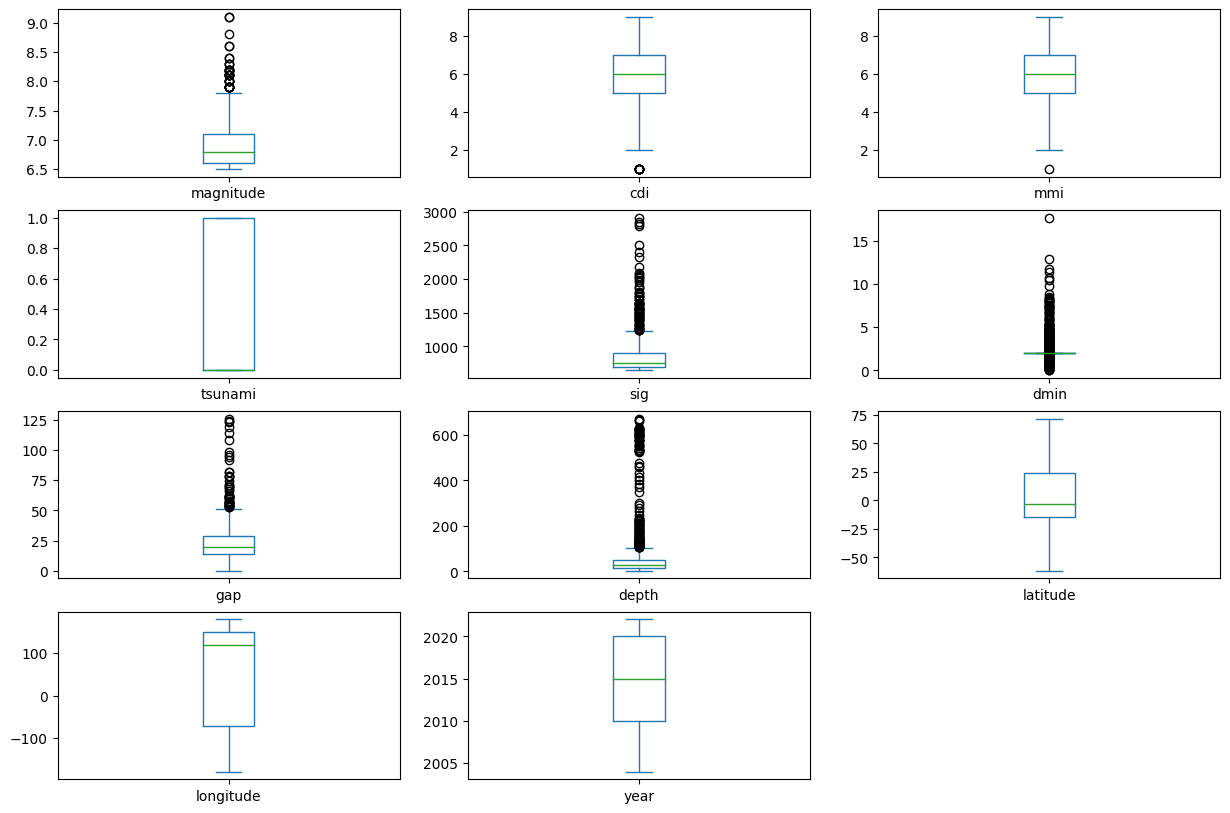

In [38]:
# Cria os gráficos Boxplot dos atributos
df_earth.plot(kind = 'box', subplots = True, layout = (4,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

Pensar em um texto pequeno explicando a distribuição dos gráficos criados

#### Visualizações Multimodais

<ipython-input-39-88300a43d124>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_earth.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);


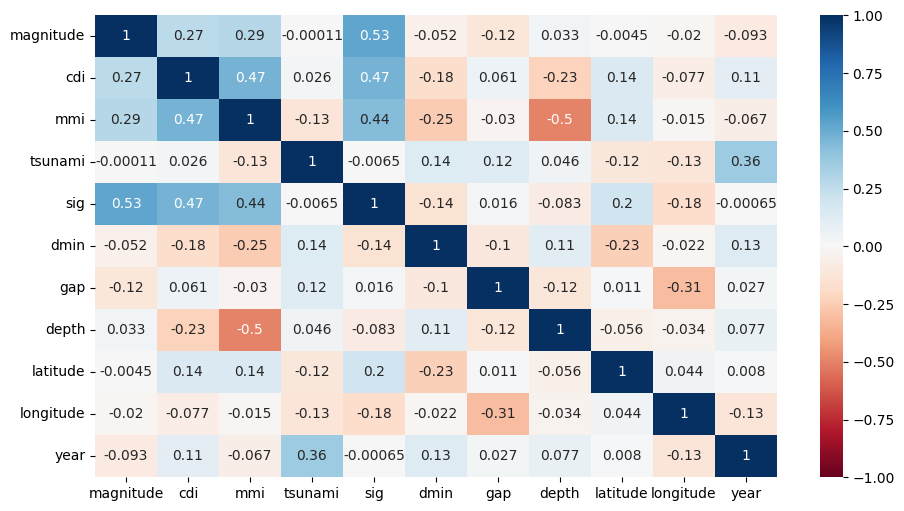

In [39]:
# Cria o gráfico de correlação de Pearson com Seaborn
plt.figure(figsize = (11,6))
sns.heatmap(df_earth.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);

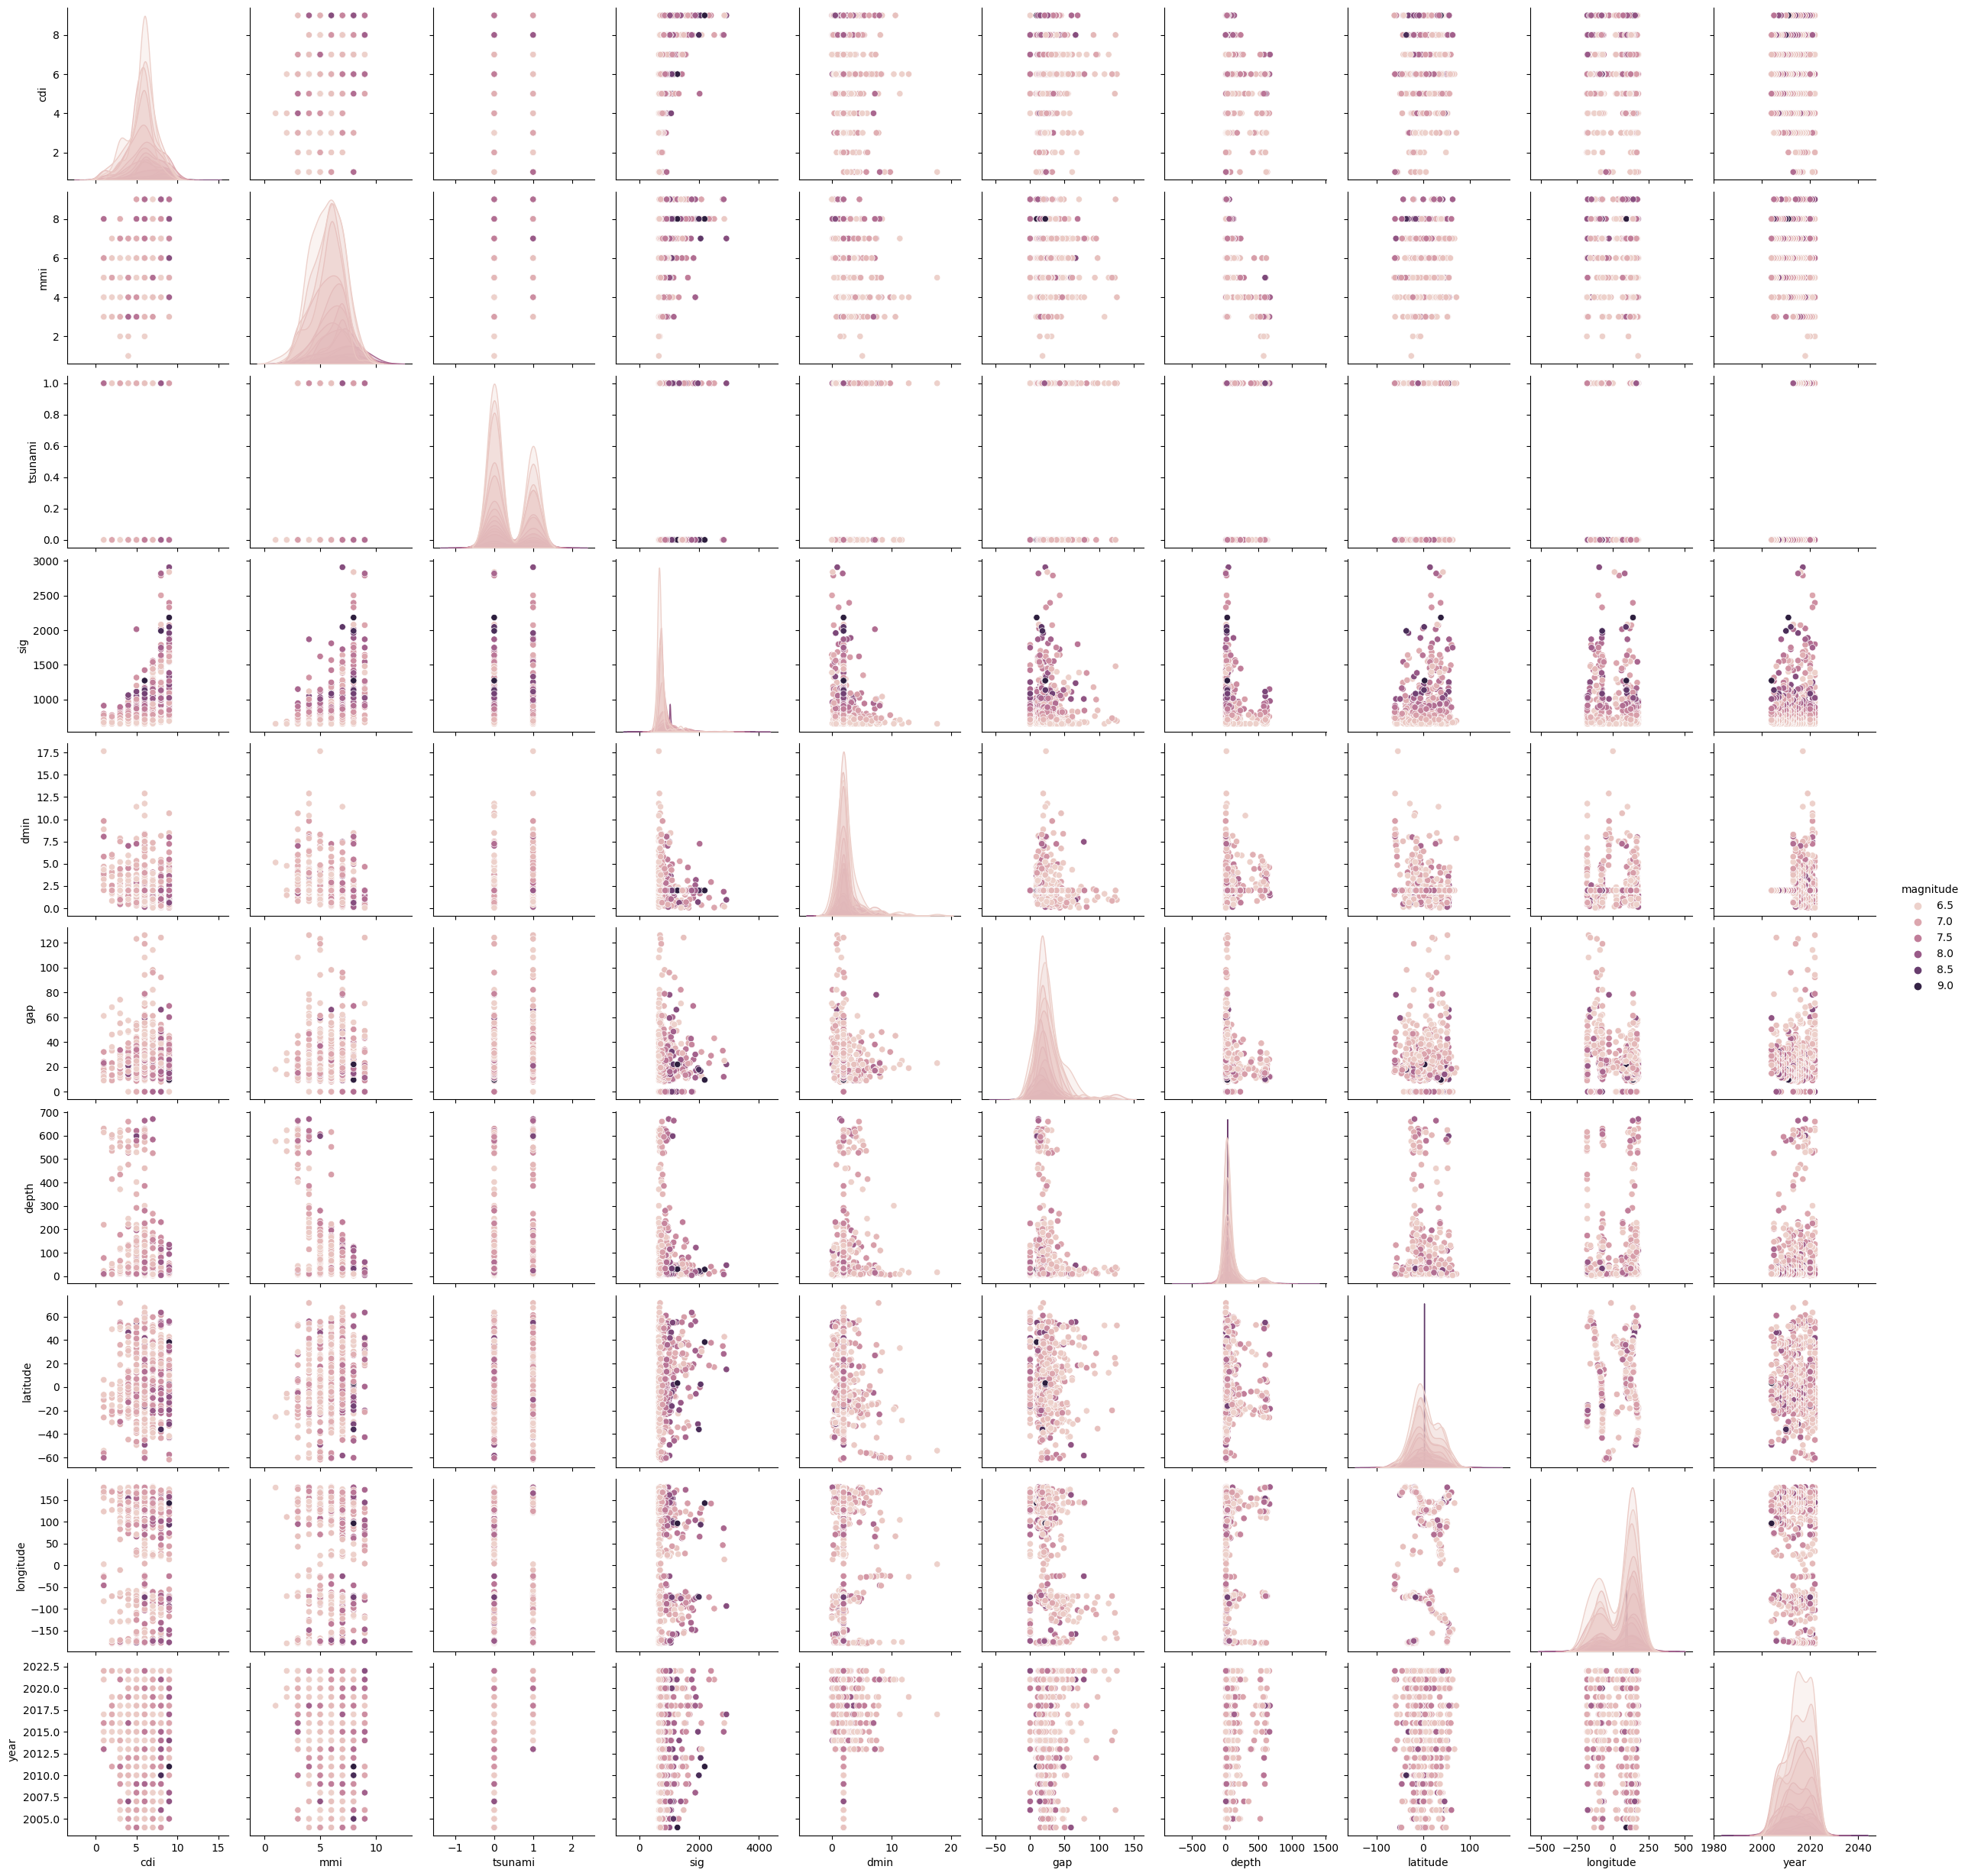

In [40]:
# Cria o Scatter Plot com Seaborn do dataframe
sns.pairplot(df_earth, hue = "magnitude", height = 2.5)

Escrever sobre as possíveis correlações que o gráfico de Pearson mostra

#### Estudo do número de terremotos por ano

In [41]:
# Agrupa os dados por ano e calcula o número de terremotos em cada ano
df_anopais = df_ano.groupby('year')['country'].count().reset_index()

In [42]:
# Mostra o resultado do agrupamento
df_anopais

,year,country
0,2004,13
1,2005,28
2,2006,26
3,2007,37
4,2008,25
5,2009,26
6,2010,39
7,2011,34
8,2012,31
9,2013,52


In [43]:
# Calcula a porcentagem de terremotos de cada ano

# Soma todos os terremotos do dataframe
total_eventos = df_anopais['country'].sum()

# Calcula a porcentagem dividindo o número de eventos por ano (x) pelo total de eventos do dataframe e multiplica por 100.
df_anopaispercent = df_anopais['country'].apply(lambda x: (x / total_eventos) * 100)

# Exibe o resultado de cada ano
df_anopaispercent

0      1.692708
1      3.645833
2      3.385417
3      4.817708
4      3.255208
5      3.385417
6      5.078125
7      4.427083
8      4.036458
9      6.770833
10     6.119792
11     6.901042
12     5.468750
13     4.687500
14     5.468750
15     4.296875
16     6.510417
17    10.937500
18     9.114583
Name: country, dtype: float64

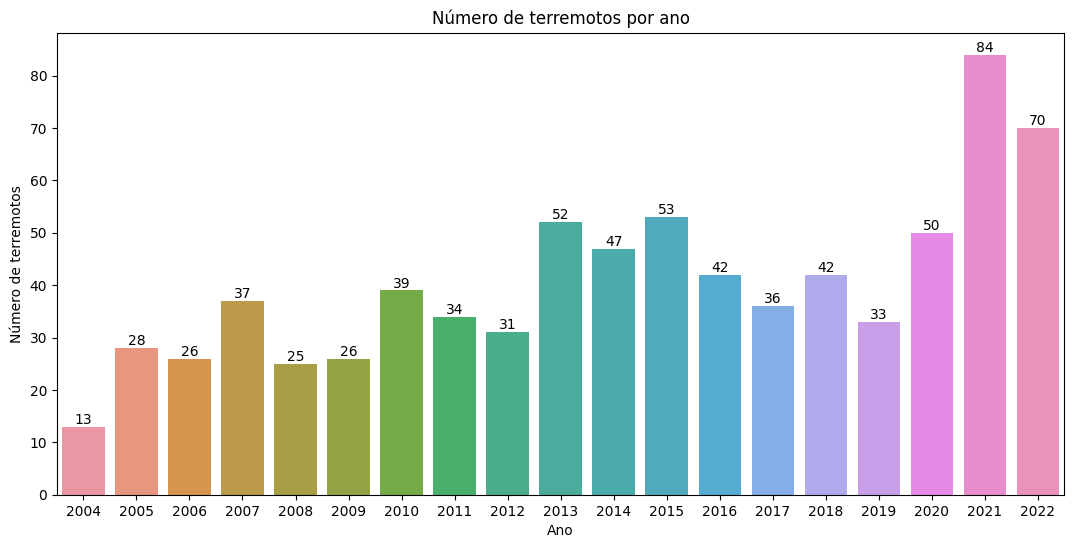

In [44]:
# Cria gráfico de barras usando a lib Seaborn
fig, ax = plt.subplots(figsize = (13,6))
sns.barplot(data=df_anopais, x='year', y='country')

#Adiciona os valores sobre as barras
ax.bar_label(ax.containers[0], fmt="%d")

# Adiciona títulos e rótulos aos eixos
plt.title('Número de terremotos por ano')
plt.xlabel('Ano')
plt.ylabel('Número de terremotos')

# Mostra o gráfico
plt.show()

Esse gráfico mostra que a ocorrência de terremotos vem aumentando nos últimos 20 anos, sendo que 20% dos terremotos ocorreram nos últimos 2 anos, como visto no calculo da porcentagem de terremotos por ano.

(array([0, 1]), [Text(0, 0, '0.0'), Text(1, 0, '1.0')])

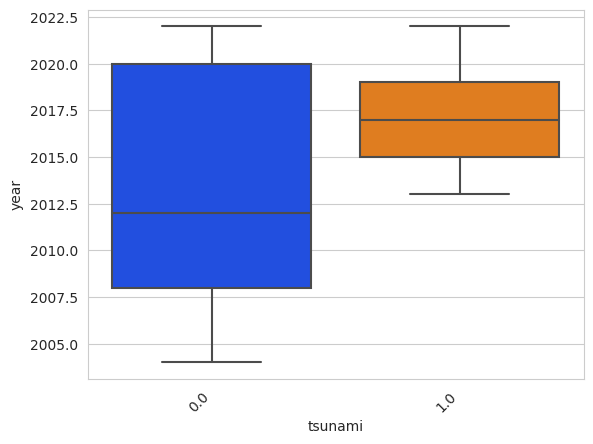

In [73]:
# Cria um boxplot usando a lib Seaborn
sns.boxplot(data=df_earth,x='tsunami',y = 'year')
plt.xticks(rotation=45,ha="right")

Um fato muito interessante é visto nesse gráfico boxplot, pois ele mostra que terremotos ocorreram na crosta oceânica (tsunami = 0) durante todo o intervalo análisado. Porém, terremos continentais (tsunami = 1) só ocorrem a partir de 2013, sendo que 50% deles ocorreram em 3 anos, entre 2015 e 2018.

#### Criação de classes para a profundidade dos eventos

Como a profundidade é muito variável, irei criar classes para poder visualizar de uma forma mais agradavél. Como a maior parte dos terremtos geralmente se concentram em profundidades de até 50m, serão criadas mais classes até essa profundidade.
- As classes criadas são as seguintes: 0-10m, 10-20m, 20-30m, 30-40m, 40-50m, 50-100m, 100-300m, 300-699m.

In [45]:
# criação de um novo dataframe para fazer o tratamento da profundidade por classe
df_classeprof = pd.DataFrame(df_earth)

In [46]:
# Cria uma nova coluna no DataFrame chamada 'depth_group' e atribui valores de acordo com a profundidade
df_classeprof['depth_group'] = pd.cut(df_classeprof['depth'], bins=[0, 10, 20, 30, 40, 50, 100, 300, 699], labels=['0-10m', '10-20m', '20-30m', '30-40m', '40-50m', '50-100m', '100-300m', '300-699m'])

# Visualiza o número de terremotos em cada classe
print(df_classeprof['depth_group'].value_counts())

10-20m      165
20-30m      145
0-10m       124
30-40m      106
100-300m     89
50-100m      52
300-699m     49
40-50m       38
Name: depth_group, dtype: int64


In [47]:
# Calcula a porcentagem de cada categoria
df_classeprofporcent = df_classeprof['depth_group'].value_counts(normalize=True).map('{:.1%}'.format)

# Visualiza a porcentagem de cada classe
df_classeprofporcent

10-20m      21.5%
20-30m      18.9%
0-10m       16.1%
30-40m      13.8%
100-300m    11.6%
50-100m      6.8%
300-699m     6.4%
40-50m       4.9%
Name: depth_group, dtype: object

In [48]:
# Mostra o resultado do agrupamento
df_classeprof

,magnitude,date,cdi,mmi,alert,tsunami,sig,dmin,gap,depth,latitude,longitude,location,continent,country,year,depth_group
0,7.0,2022-11-22,8.0,7,green,1.0,768,0.5090,17.0,14.000,-9.7963,159.596,Malango- Solomon Islands,Oceania,Solomon Islands,2022,10-20m
1,6.9,2022-11-18,4.0,4,green,0.0,735,2.2290,34.0,25.000,-4.9559,100.738,Bengkulu- Indonesia,Asia,Indonesia,2022,20-30m
2,7.3,2022-11-11,5.0,5,green,1.0,833,1.8650,21.0,37.000,-19.2918,-172.129,Neiafu- Tonga,Oceania,Tonga,2022,30-40m
3,7.0,2022-11-09,4.0,3,green,1.0,755,4.5780,26.0,660.000,-26.0442,178.381,the Fiji Islands,Oceania,Fiji,2022,300-699m
4,6.8,2022-11-09,1.0,3,green,1.0,711,4.6780,22.0,630.379,-25.9678,178.363,the Fiji Islands,Oceania,Fiji,2022,300-699m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,7.7,2020-03-31,6.0,8,green,0.0,912,1.9915,0.0,60.000,13.0490,-88.660,Puerto El Triunfo- El Salvador,Central America,El Salvador,2020,50-100m
770,6.9,2020-03-25,5.0,7,green,0.0,745,1.9915,0.0,36.400,56.7744,-153.281,Old Harbor- Alaska,North America,USA,2020,30-40m
771,7.1,2020-02-13,6.0,7,green,0.0,776,1.9915,0.0,103.000,-14.9280,167.170,Port-Olry- Vanuatu,Oceania,Vanuatu,2020,100-300m
772,6.8,2020-01-28,6.0,5,green,0.0,711,1.9915,0.0,33.000,6.6310,126.899,Mindanao- Philippines,Asia,Philippines,2020,30-40m


In [49]:
# Agrupa os dados por classe de profundidade e calcula o número de terremotos em cada classe
df_classeprof = df_classeprof.groupby('depth_group')['magnitude'].count().reset_index()

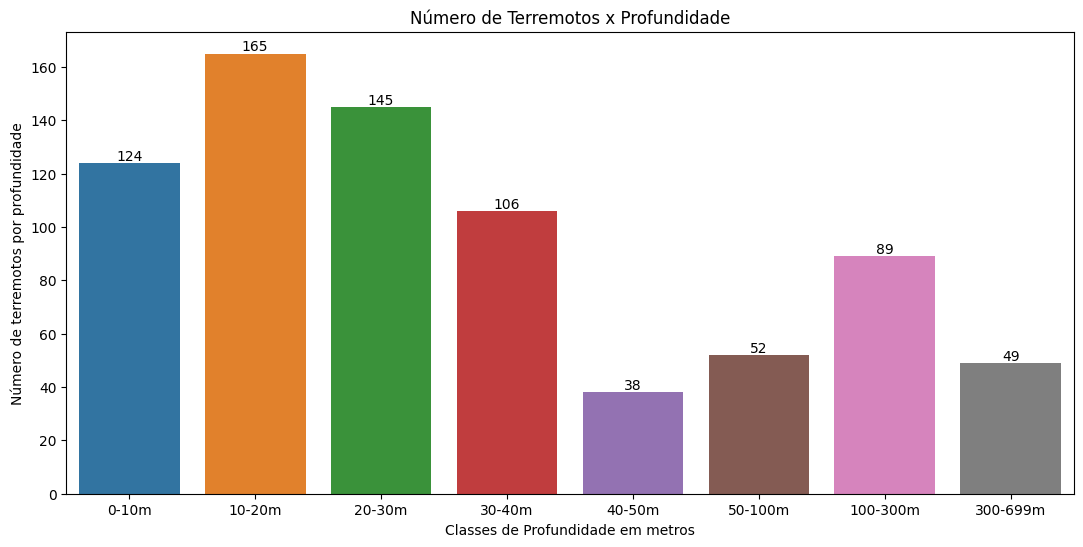

In [50]:
# Cria o gráfico de barras usando a lib Seaborn
fig, ax = plt.subplots(figsize = (13,6))
sns.barplot(data=df_classeprof, x='depth_group', y='magnitude')

# Adiciona os valores sobre as barras
ax.bar_label(ax.containers[0], fmt="%d")

# Adiciona títulos e rótulos aos eixos
plt.title('Número de Terremotos x Profundidade')
plt.xlabel('Classes de Profundidade em metros')
plt.ylabel('Número de terremotos por profundidade')

# Mostra o gráfico
plt.show()

Este gráfico mostra que a maioria dos epicentros dos terremotos se concentraram entre 10 e 20 metros de profundidade. Pelo cálculo da porcentagem, podemos ver mais de 70% dos epicentros ocorreram em até 40 metros de profundidade.

(array([0, 1]), [Text(0, 0, '0.0'), Text(1, 0, '1.0')])

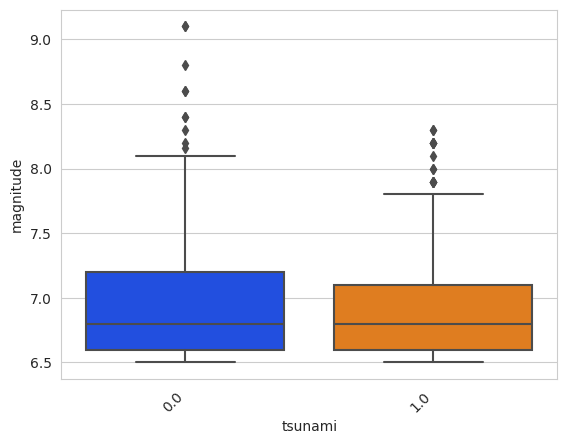

In [71]:
# Cria um boxplot usando a lib Seaborn
sns.boxplot(data=df_earth,x='tsunami',y = 'magnitude')
plt.xticks(rotation=45,ha="right")

(array([0, 1]), [Text(0, 0, '0.0'), Text(1, 0, '1.0')])

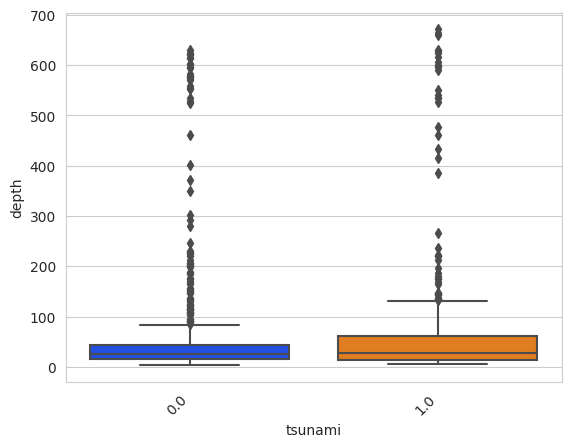

In [72]:
# Cria um boxplot usando a lib Seaborn
sns.boxplot(data=df_earth,x='tsunami',y = 'depth')
plt.xticks(rotation=45,ha="right")

Análisando os dois gráficos boxplot acima, é possível ver terremotos que ocorreram na crosta oceânica (tsunami = 0), possuemtiveram magnitude maior no geral, comparados com os terremotos continentais (tsunami = 1). Em contra partida, os continentais ocorreram em profundidade maiores.

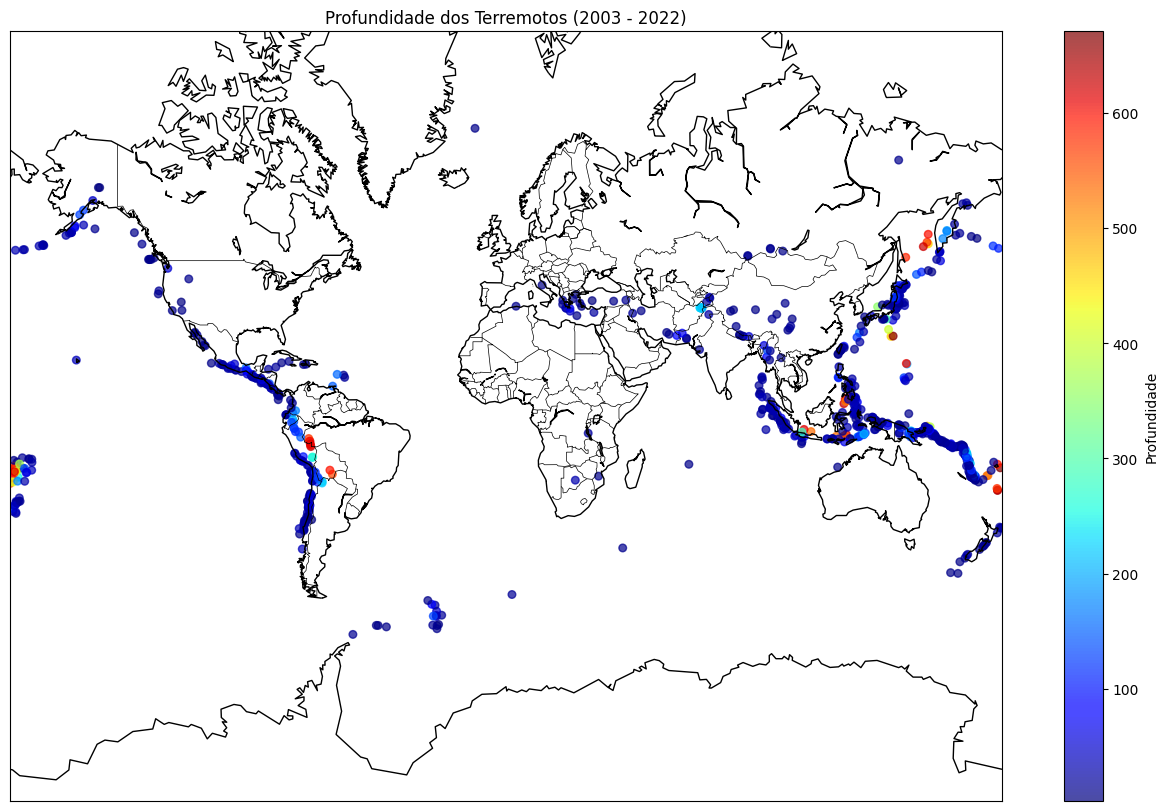

In [51]:
## Mapa que mostra a profundidade dos terremotos
# Cria um mapa usando o Basemap
fig = plt.figure(figsize=(16, 10))
map = Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80,
              llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

# Desenha a costa e as fronteiras dos países
map.drawcoastlines()
map.drawcountries()

# Converte as coordenadas de latitude e longitude em coordenadas de mapa
x, y = map(list(df_earth['longitude']), list(df_earth['latitude']))

# Cria um mapa de calor da profundidade dos terremotos
plt.scatter(x, y, c=df_earth['depth'], s=30, cmap='jet', alpha=0.7)

# Adiciona um título e uma barra de cores à figura
plt.colorbar(label='Profundidade')
plt.title('Profundidade dos Terremotos (2003 - 2022)')

# Mostra a figura
plt.show()

Este mapa mostra bem como a grande maioria dos terremotos ocorreram em profundidades de até 200 metros. Assim como os mais profundos também ocorreram em crosta continental, localizados principalmente na Indonésia e no Andes.

#### Estudo por Continentes

In [52]:
# criação de um novo dataframe para fazer o tratamento da profundidade por classe
df_continent = pd.DataFrame(df_earth)

In [53]:
# Agrupa os terremotos por ano e continente, mostrando a quantidade de terremotos em cada grupo
df_continent = df_continent.groupby(['year', 'continent']).size().reset_index(name='count')

# Exibi as 5 primeiras linhas do dataframe
df_continent.head()

,year,continent,count
0,2004,Asia,6
1,2004,Central America,1
2,2004,North America,1
3,2004,Oceania,4
4,2004,South America,1


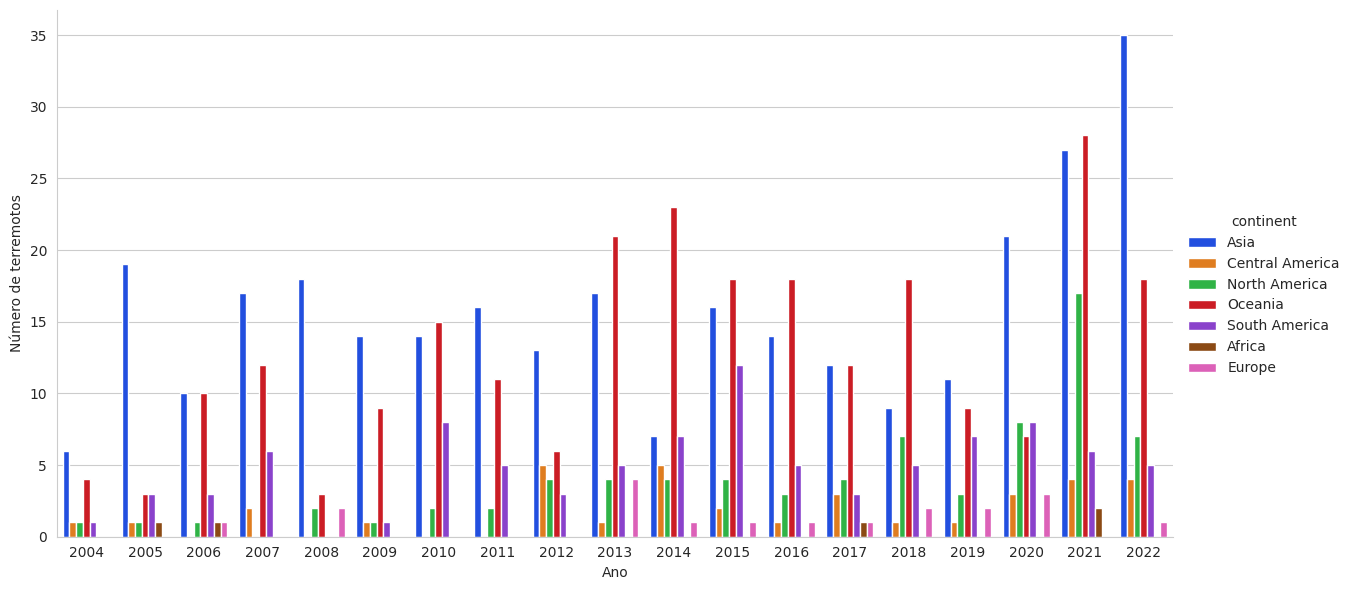

In [67]:
# Cria um gráfico de barras empilhadas para o número de terremotos por ano em cada continente
sns.set_palette('bright')
sns.set_style('whitegrid')
g = sns.catplot(x='year', y='count', hue='continent', data=df_continent, kind='bar', height=6, aspect=2)

# Adiciona rótulos aos eixos
g.set_axis_labels('Ano', 'Número de terremotos')

# Mostra o gráfico
plt.show()

Por esse gráfico é possível notar que ocorreram terremotos nos últimos 20 na Asia e Oceania. Ainda é possível identificar pulsos de maiores ocorrências entre esses dois continentes. Desta forma, podemos criar 3 intervalos de maior número de ocorrêcias:
- Entre os anos de 2004 - 2012: x% dos terremotos ocorrem na Asia;
- Entre os anos de 2012 - 2018: x% dos terremotos ocorrem na Oceania;
- Entre os anos de 2018 - 2022: x% dos terremotos ocorrem na Asia;

Interessante ver que somente no ano de 2017 ocorreu terremotos em todos os continentes. Assim como não ocorrem terremotos em 2007  e 2008 na América do Norte e Amércia do Sul respectivamente.  

In [55]:
# criação de um novo dataframe para fazer a correlação de terremotos por ano e continente
df_anocont = pd.DataFrame(df_earth)

In [56]:
# Agrupa os dados por continente e conta o número de terremotos em cada grupo
df_anocont = df_ano.groupby('continent').size().reset_index(name='count')

# Exibi o dataframe
df_anocont

,continent,count
0,Africa,5
1,Asia,296
2,Central America,35
3,Europe,19
4,North America,75
5,Oceania,245
6,South America,93


In [57]:
# Ordena os dados pelo número de terremotos em ordem decrescente
df_anocont = df_anocont.sort_values(by='count', ascending=False)

# Exibi o dataframe em ordem decrescente de eventos
df_anocont

,continent,count
1,Asia,296
5,Oceania,245
6,South America,93
4,North America,75
2,Central America,35
3,Europe,19
0,Africa,5


In [58]:
# Calcula a porcentagem de terremotos por continente

# Soma todos os terremotos do dataframe
total_eventos = df_anocont['count'].sum()

# Calcula a porcentagem dividindo o número de eventos por ano (x) pelo total de eventos do dataframe e multiplica por 100.
df_anocontpercent = df_anocont['count'].apply(lambda x: (x / total_eventos) * 100)

# Exibe o resultado de cada ano
df_anocontpercent

1    38.541667
5    31.901042
6    12.109375
4     9.765625
2     4.557292
3     2.473958
0     0.651042
Name: count, dtype: float64

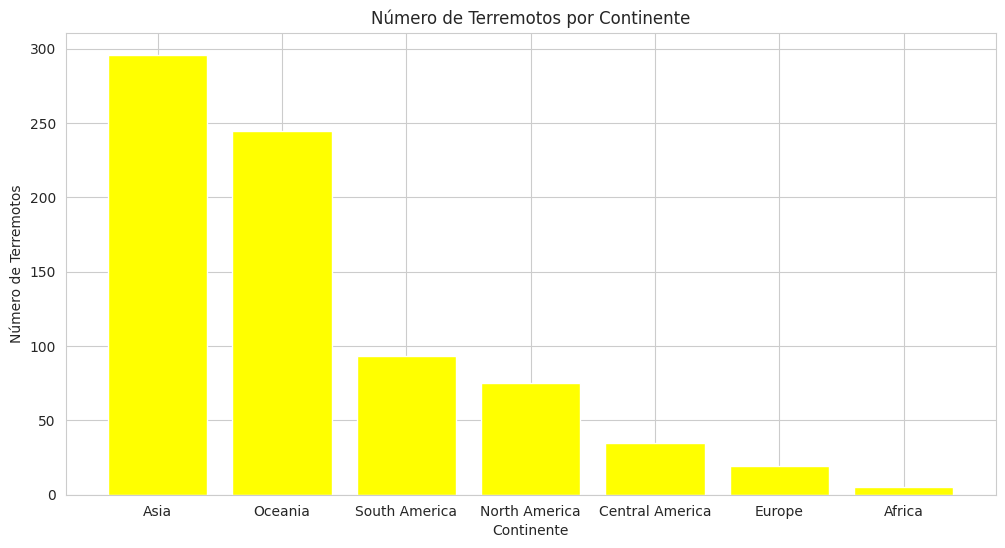

In [59]:
# Cria um gráfico de barras em ordem decrescente de ocorrência de terremotos por continente
fig = plt.figure(figsize=(12, 6))
plt.bar(df_anocont['continent'], df_anocont['count'], color='yellow')

# Adiciona um título e rótulos de eixo
plt.title('Número de Terremotos por Continente')
plt.xlabel('Continente')
plt.ylabel('Número de Terremotos')

# Exibe o gráfico
plt.show()

Esse gráfico corrobora a interpretação do gráfico de eventos por ano em cada continente, onde vemos a maior concentração de terremotos nas bordas da plata tectônica do oceano Pacífico. Essas bordas recebem o "apelido" de cintirão de fogo, pois estão localizadas sobre zonas de subducção de placas tectônicas. Local esse altemente sujeito terremotos. Calculando as porcentagens desses eventos, podemos ver os terremotos que abrangem os limites dessa placa totalizam 92% de todos os terremotos nos últimos 20 anos.

Colocar a figura que vou tentar montar mostando as bordas das placas tectonicas

#### Estudo por Países

In [60]:
# criação de um novo dataframe para fazer a correlação de terremotos por ano e país
df_pais = pd.DataFrame(df_earth)

# Exibe as 5 primeiras linhas do dataframe
df_pais.head()

,magnitude,date,cdi,mmi,alert,tsunami,sig,dmin,gap,depth,latitude,longitude,location,continent,country,year,depth_group
0,7.0,2022-11-22,8.0,7,green,1.0,768,0.509,17.0,14.000,-9.7963,159.596,Malango- Solomon Islands,Oceania,Solomon Islands,2022,10-20m
1,6.9,2022-11-18,4.0,4,green,0.0,735,2.229,34.0,25.000,-4.9559,100.738,Bengkulu- Indonesia,Asia,Indonesia,2022,20-30m
2,7.3,2022-11-11,5.0,5,green,1.0,833,1.865,21.0,37.000,-19.2918,-172.129,Neiafu- Tonga,Oceania,Tonga,2022,30-40m
3,7.0,2022-11-09,4.0,3,green,1.0,755,4.578,26.0,660.000,-26.0442,178.381,the Fiji Islands,Oceania,Fiji,2022,300-699m
4,6.8,2022-11-09,1.0,3,green,1.0,711,4.678,22.0,630.379,-25.9678,178.363,the Fiji Islands,Oceania,Fiji,2022,300-699m


In [61]:
# criando um novo dataframe com a quantidades de terremotos por país
df_pais_counts = df_pais['country'].value_counts()

# Exibe as 5 primeiras linhas do dataframe
df_pais_counts

Indonesia           120
Japan                64
Papua New Guinea     64
Chile                49
Vanuatu              43
                   ... 
Jamaica               1
Mongolia              1
Mauritius             1
Cyprus                1
Guam                  1
Name: country, Length: 63, dtype: int64

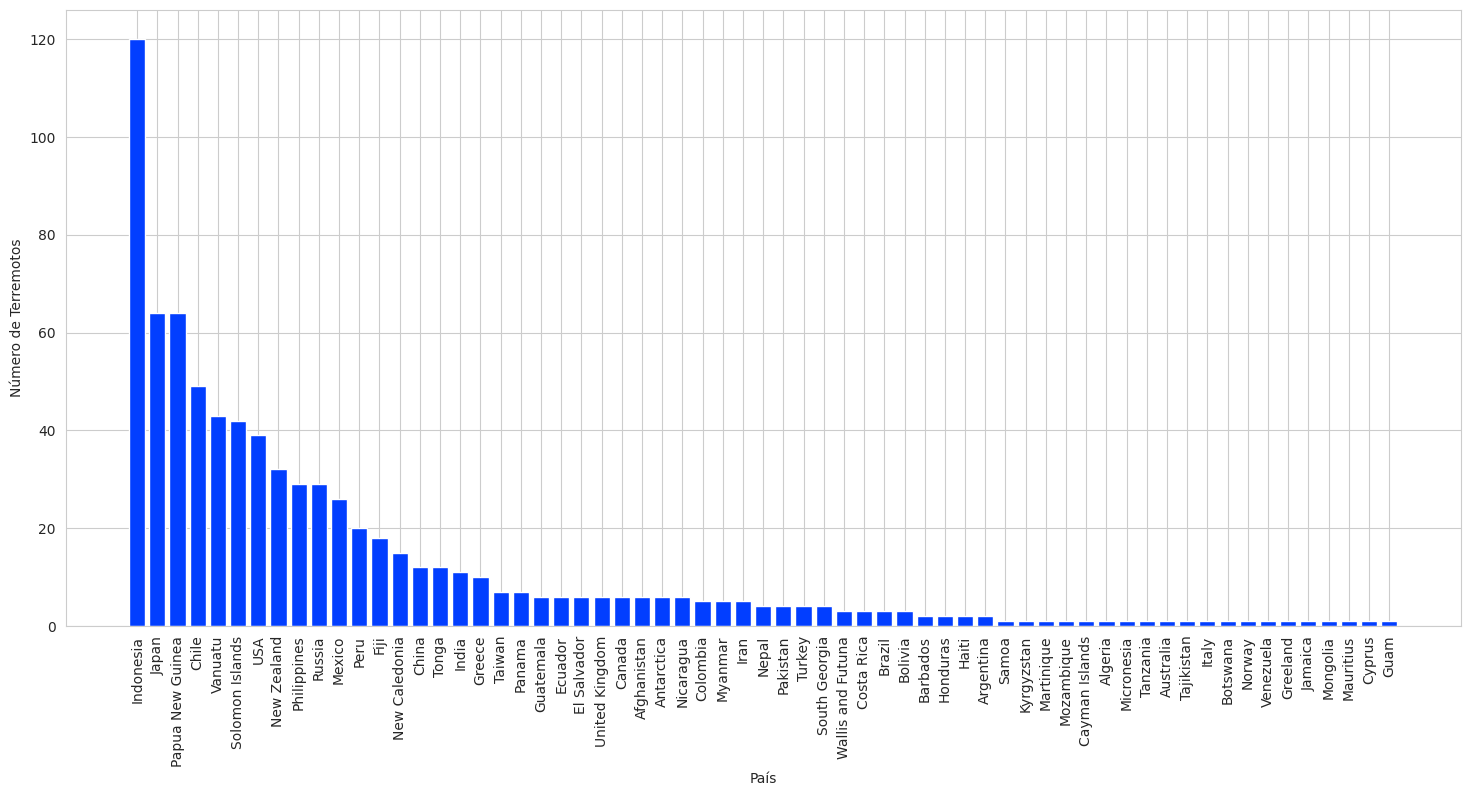

In [62]:
# Cria um gráfico de barras por ordem decrescente de eventos por país
fig = plt.figure(figsize=(18, 8))
plt.bar(df_pais_counts.index, df_pais_counts.values)

# Adiciona títulos e rótulos aos eixos
plt.xlabel('País')
plt.ylabel('Número de Terremotos')

# Exibe o nome dos paises na vertical
plt.xticks(rotation=90)

# Mostra o gráfico
plt.show()

Interpretar esse gráfico e corroborar no mapa abaixo

In [63]:
# Agrupa os dados por continente e conta o número de terremotos em cada grupo
df_pais_count = df_ano.groupby('country').size().reset_index(name='counts')

# Exibi o dataframe
df_pais_count

,country,counts
0,Afghanistan,6
1,Algeria,1
2,Antarctica,6
3,Argentina,2
4,Australia,1
...,...,...
58,USA,39
59,United Kingdom,6
60,Vanuatu,43
61,Venezuela,1


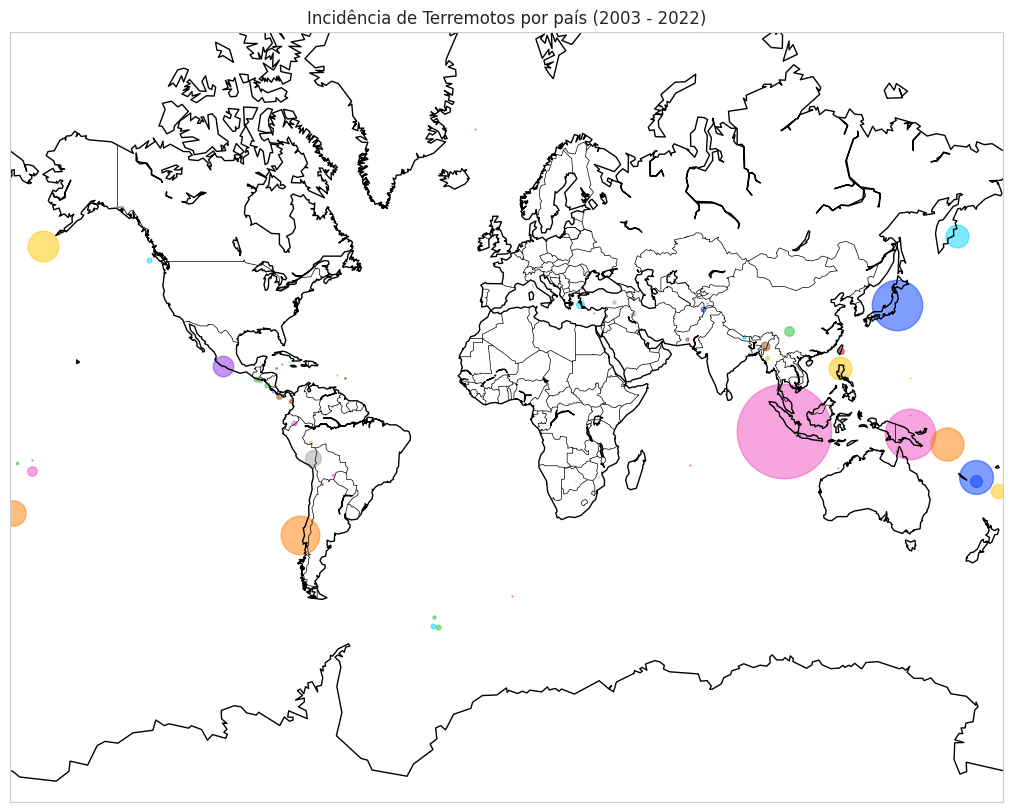

In [64]:
# Mapa com bublleplot
# Cria um mapa mundi mostrando o total de ocorrências por país 
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1)
map = Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80,
              llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

# Converte as coordenadas de lat/lon para x/y
x, y = map(df_ano['longitude'].values, df_ano['latitude'].values)

# Desenha o mapa
map.drawcoastlines()
map.drawcountries()

# Desenha as bolhas no mapa
scale_factor = 0.32  # ajusta o tamanho das bolhas
for i, row in df_pais_count.iterrows():
    count = row['counts']
    if count > 0:
        x_pt, y_pt = map(df_ano[df_ano['country'] == row['country']]['longitude'].values[0], 
                         df_ano[df_ano['country'] == row['country']]['latitude'].values[0])
        area = np.pi * (scale_factor * count) ** 2
        ax.scatter(x_pt, y_pt, s=area, alpha=0.5)

# Adiciona um título
plt.title('Incidência de Terremotos por país (2003 - 2022)')

plt.show()

Conclusão?!?!?!?!?